## Evaluation Notebook #1

Prior to running this notebook, ensure that binary nuclear masks have been generated for all the fields you have sampled from the dataset. There should be one binary mask from each segmentation platform for a field. Next, put all the binary masks for one field in a directory, and all the binary masks for another field in a different directory. As a result, there should be one directory for each field, where the directories contain the binary nuclear masks from the platforms being evaluated. Please note that all masks should be tiff files.

The next step is to select four 256X256 pixel sub-fields for evaluation from each field and record their coordinates. Ground truth nuclear annotations can then be created in GIMP for the subfields. Two of these regions should be selected for sparse while the other two for densely populated regions of nuclei to evaluate nuclear segmentation over a range of nuclear density (if possible). Effort should also made to sample one sub-region from each of the four quadrants of the fields to ensure exhaustive spatial sampling for evaluation.

In GIMP, load the gray scaled DAPI channel for the field and crop the image according to the coordinates for the first evaluation sub-field. Add a new layer over the DAPI image with a medium level of opacity so that the DAPI signal can still be clearly visualized by the annotators. The boundaries of nuclei can then annotated using a 1x1 pixel square brush and filled in with a bucket fill tool of white (foreground). A 2x2 square pixel brush of black (background) must used to add a dividing line between touching nuclei. The DAPI signal layer is then hidden and the opacity of the annotated binary mask layer can be turned to 100% prior to exporting the ground truth binary mask. Repeat this process for all evaluation subfields from all WSI fields.

As a result, there should be one directory for each field, where the directories contain four ground truth binary nuclear masks, one for each evaluation sub-field. Please note that all masks should be tiff files.


The recommended file structure for storing the segmentation platform-derived nuclear binary masks and the ground truth masks are as follows:

```
Base
|-Field1
||-Platform_masks
|||-Platform1.tiff
|||-Platform2.tiff
|||-Platform3.tiff
||-ground_truth_masks
|||-gr_tr_sparse1.tiff
|||-gr_tr_sparse2.tiff
|||-gr_tr_dense1.tiff
|||-gr_tr_dense2.tiff
|-Field2
||-Platform_masks
|||-Platform1.tiff
|||-Platform2.tiff
|||-Platform3.tiff
||-ground_truth_masks
|||-gr_tr_sparse1.tiff
|||-gr_tr_sparse2.tiff
|||-gr_tr_dense1.tiff
|||-gr_tr_dense2.tiff
```

Build the directory structure for as many fields and platforms as required. Storing the binary masks with this file structure will allow compatibility with the evaluation code below. The file structure above will also be referenced in the code below (in the comments) for ease of use.

This notebooks allows for qualitative evaluation in the form of images of platform binary masks overlayed on ground truth masks for comparison as well quantitative evaluation in the form of F1-scores at varying IoU thresholds.

Run separate notebooks for each WSI field to be evaluated. After running a similar notebook for multiple fields of a dataset, use the `all_fields.ipynb` notebook to combine the data to quantitatively compare the nuclear segmentation performance of the platforms across all the fields sampled from the dataset. This should give an idea of the relative nuclear segmentation performances of the platforms across the entire dataset.

In [1]:
import os
import skimage.io as io
import pandas as pd
import numpy as np
import skimage.morphology
import skimage.segmentation
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff as hausdorff
from scipy import stats
import sigfig
import seaborn as sns
from evaluation import intersection_over_union
from evaluation import F1_score_calculator
sns.set_style("whitegrid")

The below cell consists of the inputs that the user needs to provide. Change these according to the file paths on the local machine, the coordinates of the four evaluation sub-fields, and the list of platforms being implemented and evaluated:

In [2]:
# Change these filepaths to access files on a local machine

# These are the outputs for the notebook. The plots give us relative platform performance on this particular field. The csv files will be used in
# Evaluation Notebook #2 when compiling the evaluations for multiple fields of the dataset.
# Path to save the csv file contaning the platform F1-scores for each subfield at 0.5 IoU
F1_5IoU_csv_path = r'C:\Users\mrl\Desktop\nuclear_seg_github\imgs\F1_5IoU_csv\Tonsil7color.csv'
# Path to save the bar plot contaning the platform F1-scores at 0.5 IoU
F1_5IoU_plot_path = r'C:\Users\mrl\Desktop\nuclear_seg_github\imgs\F1_5IoU_plot\Tonsil7color.png'
# Path to save the csv file contaning the platform F1-scores for each subfield at a range of IoUs
F1_allIoU_csv_path = r'C:\Users\mrl\Desktop\nuclear_seg_githubn\imgs\F1_allIoU_csv\Tonsil7color.csv'
# Path to save the line plot contaning the platform F1-scores at a range of IoUs
F1_allIoU_plot_path = r'C:\Users\mrl\Desktop\nuclear_seg_github\imgs\F1_allIoU_plot\Tonsil7color.png'

# Path to the directory containing the binary masks of the whole field from each platform (e.g. Base/Field1/Platform_masks)
platforms_dir_path = r'C:\Users\mrl\Desktop\nuclear_seg_github\imgs\Fields\Tonsil_7color_Scan2_17096_47011\Platforms'

# Path to the directory the four ground truth sub fields (e.g. Base/Field1/ground_truth_masks)
gr_tr_dir_path = r'C:\Users\mrl\Desktop\nuclear_seg_github\imgs\Fields\Tonsil_7color_Scan2_17096_47011\ground_truth'

# Coordinates of the top-left corner of the four subfields, with the dictionary keys being the subfield ID
coordinate_dict = {'sparse1': (103, 57),'dense1': (1140, 1044), 'sparse2': (914, 627), 'dense2': (232, 1304)}

# Path to save overlayed images (platform masks on ground truth) for qualitative evaluation of segmentation
eval_images_path = r'C:\Users\mrl\Desktop\nuclear_seg_github\imgs\eval_images\Tonsil7Color'

# Enter the platforms you have implemented on your sample fields. Make sure that the binary masks in 'Base/Field1/Platform_masks' have the same
# filenames as these platforms.
platform_list = ['ilastik', 'CellProfiler', 'Fiji', 'QuPath', 'Mesmer', 'InForm', 'CellPose', 'StarDist']

There are no more user inputs required. The cells below should be able to run without any required editions.

In [ ]:
# Reading the ground truth binary masks into arrays. Make sure that the ground truth binary masks are named
# according to the file names shown below
gr_tr_sparse1 = io.imread(os.path.join(gr_tr_dir_path, 'gr_tr_sparse1.tiff'))
gr_tr_sparse2 = io.imread(os.path.join(gr_tr_dir_path, 'gr_tr_sparse2.tiff'))
gr_tr_dense1 = io.imread(os.path.join(gr_tr_dir_path, 'gr_tr_dense1.tiff'))
gr_tr_dense2 = io.imread(os.path.join(gr_tr_dir_path, 'gr_tr_dense2.tiff'))
# Dictionary with keys being the string containing the name of the subfield and the values being the ground 
# truth arrays
gr_tr_mask_dict = {'sparse1': gr_tr_sparse1, 'sparse2': gr_tr_sparse2, 'dense1': gr_tr_dense1,
                   'dense2': gr_tr_dense2}

The below code is used to generate a dataframe where the columns are the platforms being implemented and the rows are the F1 scores for each evaluation subfield at 0.5 intersection over union (IoU) threshold. This means that a predicted nucleus has to have at least 0.5 IoU to be counted as a true positive. Having an IoU threshold of 0.5 or above ensures that there is a maximum of one true positive predicted nucleus for every ground truth nucleus. The code is also used to generate the overlays of platform nuclei masks on ground truth nuclei masks for qualitative evaluation.

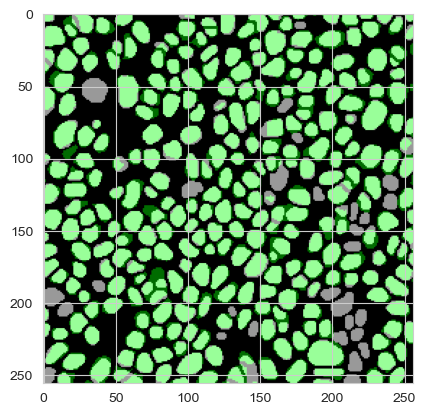

CellPose_sparse1
TP:262, FP:35, FN:61, ground truth nuclei:323
F1-score:0.8451612903212175


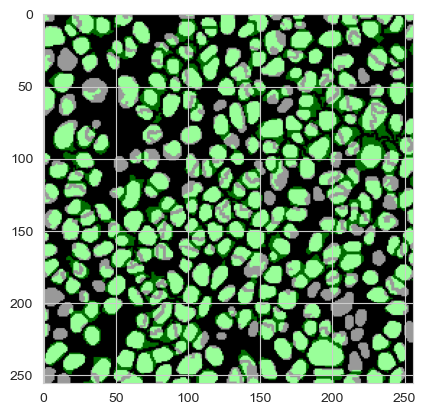

CellProfiler_sparse1
TP:148, FP:143, FN:175, ground truth nuclei:323
F1-score:0.48208469055296077


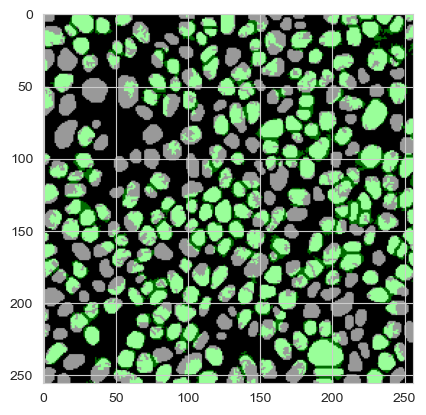

Fiji_sparse1
TP:125, FP:105, FN:198, ground truth nuclei:323
F1-score:0.45207956600279914


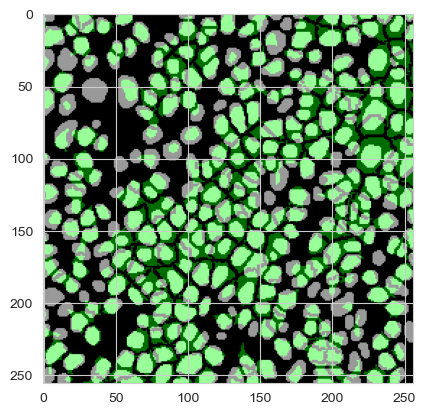

ilastik_sparse1
TP:97, FP:151, FN:226, ground truth nuclei:323
F1-score:0.33975481611148906


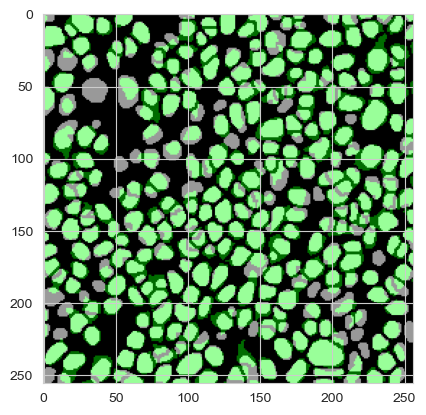

InForm_sparse1
TP:176, FP:93, FN:147, ground truth nuclei:323
F1-score:0.5945945945935902


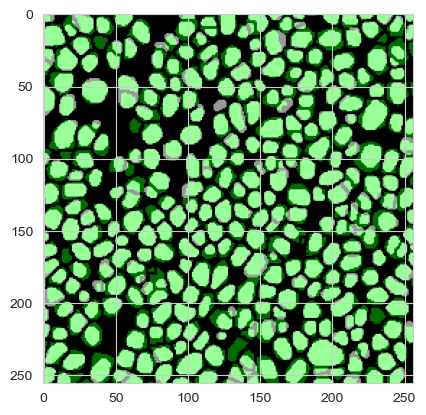

Mesmer_sparse1
TP:268, FP:64, FN:55, ground truth nuclei:323
F1-score:0.8183206106857736


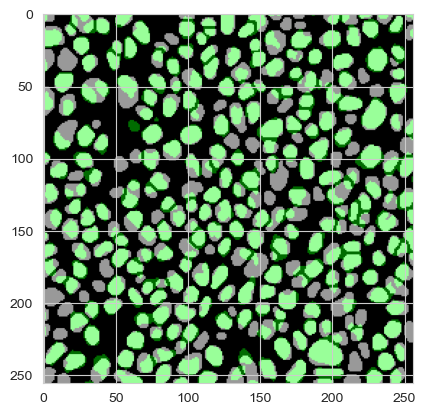

QuPath_sparse1
TP:164, FP:76, FN:159, ground truth nuclei:323
F1-score:0.5825932504430149


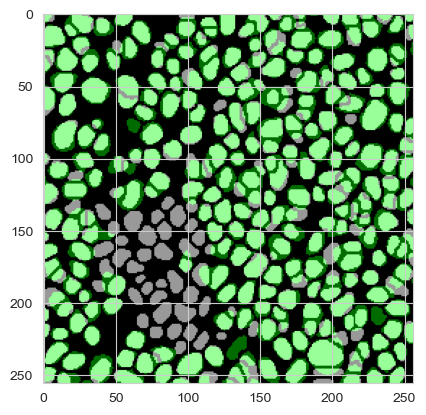

StarDist_sparse1
TP:179, FP:66, FN:144, ground truth nuclei:323
F1-score:0.6302816901397355


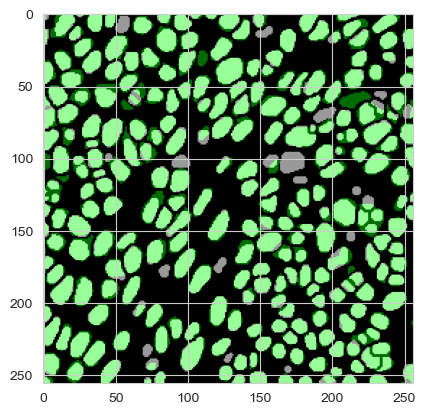

CellPose_sparse2
TP:227, FP:33, FN:46, ground truth nuclei:273
F1-score:0.8517823639758878


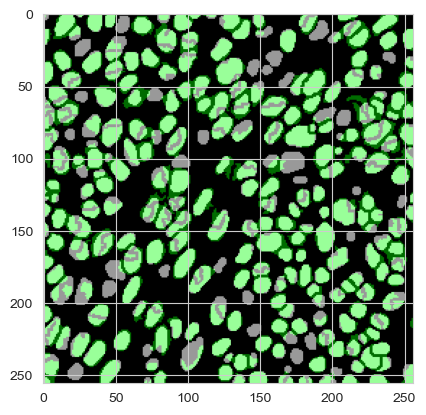

CellProfiler_sparse2
TP:115, FP:132, FN:158, ground truth nuclei:273
F1-score:0.44230769230684175


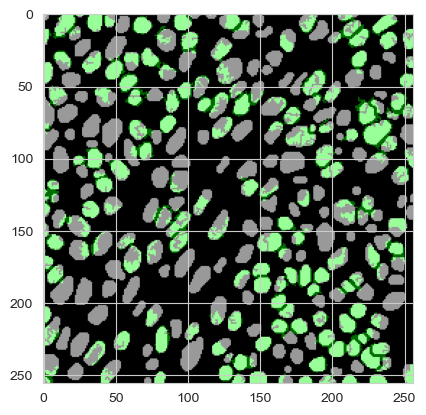

Fiji_sparse2
TP:76, FP:82, FN:197, ground truth nuclei:273
F1-score:0.3526682134562583


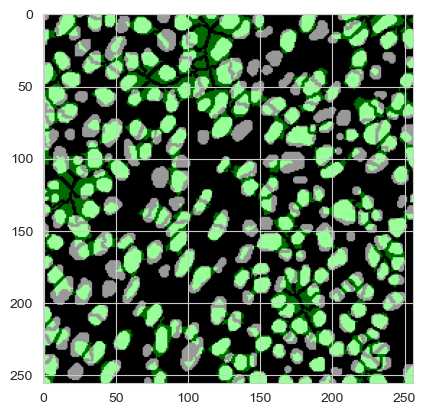

ilastik_sparse2
TP:87, FP:130, FN:186, ground truth nuclei:273
F1-score:0.3551020408156018


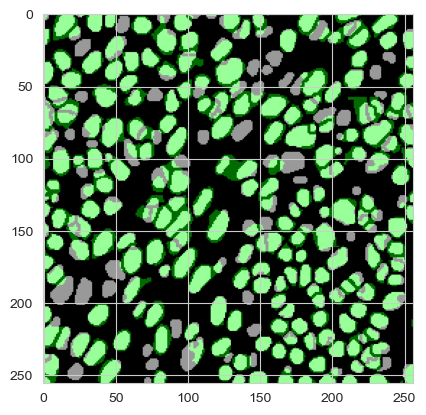

InForm_sparse2
TP:147, FP:58, FN:126, ground truth nuclei:273
F1-score:0.6150627615049894


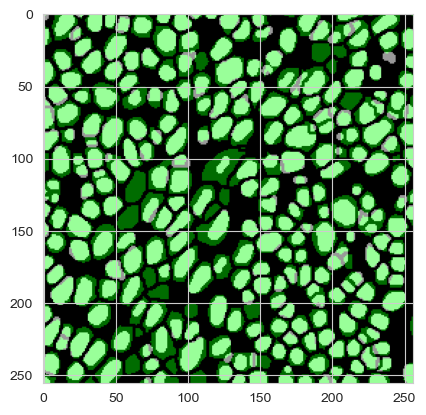

Mesmer_sparse2
TP:213, FP:76, FN:60, ground truth nuclei:273
F1-score:0.7580071174363736


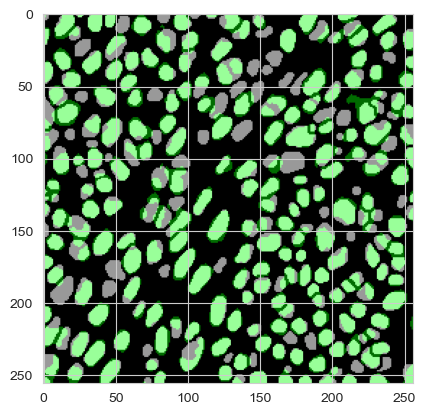

QuPath_sparse2
TP:152, FP:56, FN:121, ground truth nuclei:273
F1-score:0.6320166320153181


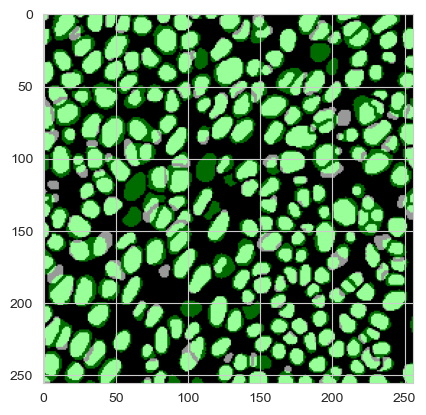

StarDist_sparse2
TP:198, FP:62, FN:75, ground truth nuclei:273
F1-score:0.7429643527190564


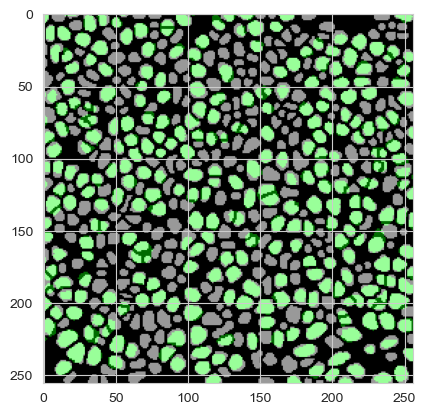

CellPose_dense1
TP:256, FP:42, FN:305, ground truth nuclei:561
F1-score:0.5960419091960465


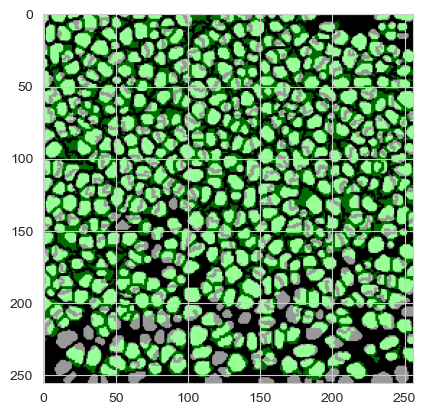

CellProfiler_dense1
TP:114, FP:268, FN:447, ground truth nuclei:561
F1-score:0.24178154825000872


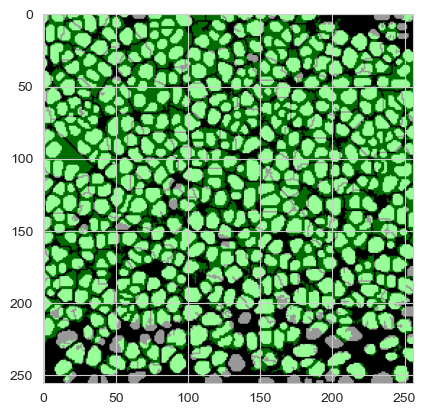

Fiji_dense1
TP:103, FP:173, FN:458, ground truth nuclei:561
F1-score:0.2461170848264682


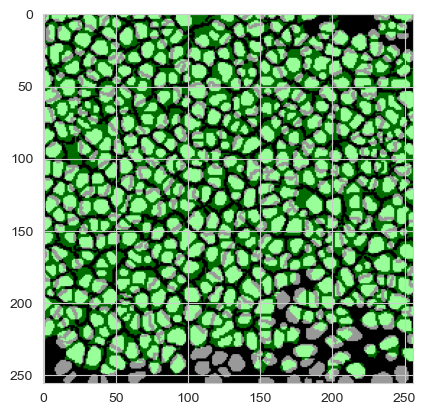

ilastik_dense1
TP:62, FP:229, FN:499, ground truth nuclei:561
F1-score:0.14553990610311557


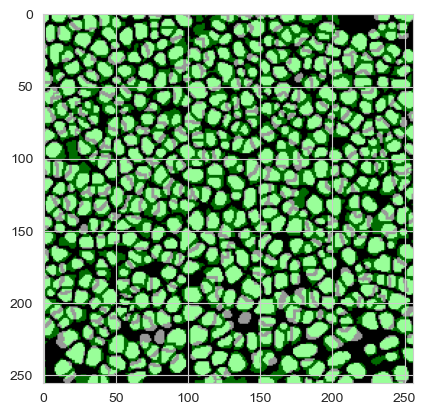

InForm_dense1
TP:156, FP:271, FN:405, ground truth nuclei:561
F1-score:0.31578947368389093


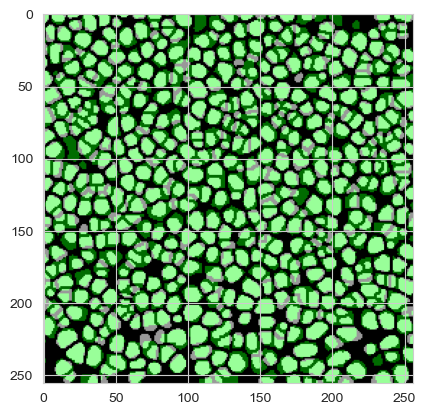

Mesmer_dense1
TP:254, FP:176, FN:307, ground truth nuclei:561
F1-score:0.5126135216947401


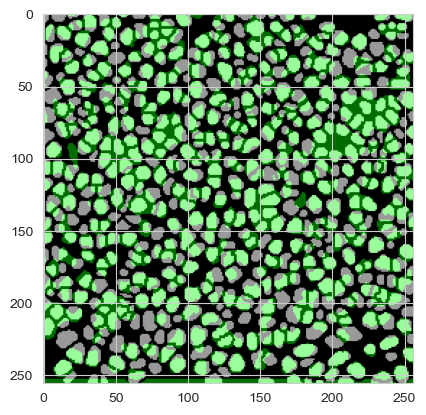

QuPath_dense1
TP:111, FP:159, FN:450, ground truth nuclei:561
F1-score:0.2671480144401117


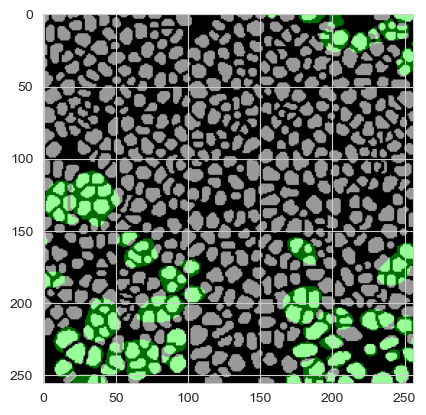

StarDist_dense1
TP:24, FP:29, FN:537, ground truth nuclei:561
F1-score:0.07817589576534499


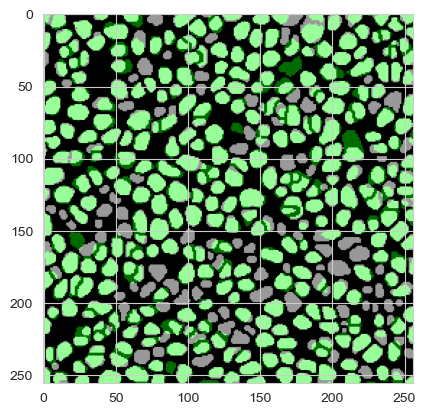

CellPose_dense2
TP:252, FP:58, FN:178, ground truth nuclei:430
F1-score:0.6810810810801607


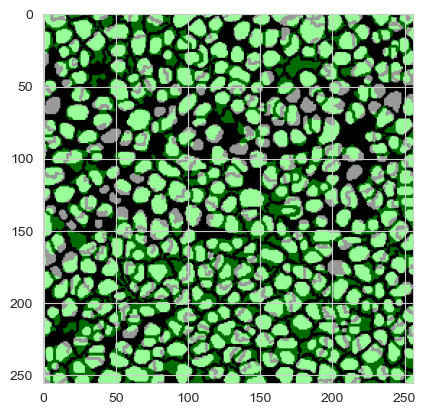

CellProfiler_dense2
TP:113, FP:240, FN:317, ground truth nuclei:430
F1-score:0.28863346104688553


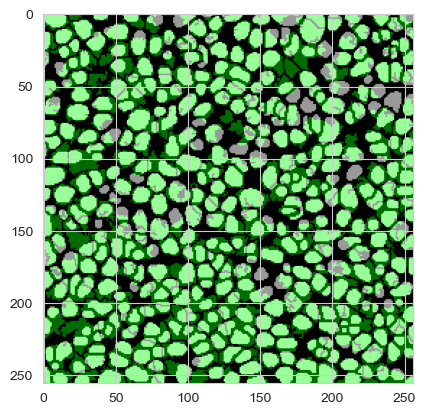

Fiji_dense2
TP:143, FP:166, FN:287, ground truth nuclei:430
F1-score:0.3870094722592869


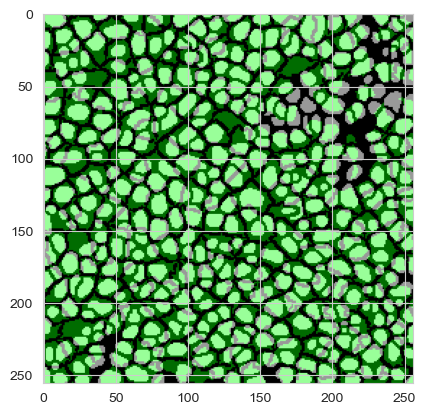

ilastik_dense2
TP:79, FP:212, FN:351, ground truth nuclei:430
F1-score:0.21914008321744918


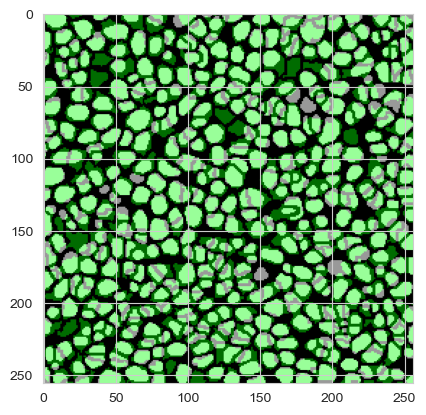

InForm_dense2
TP:166, FP:235, FN:264, ground truth nuclei:430
F1-score:0.39951865222575267


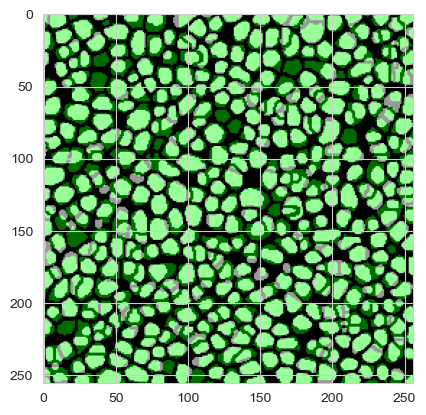

Mesmer_dense2
TP:248, FP:143, FN:182, ground truth nuclei:430
F1-score:0.6041412911076686


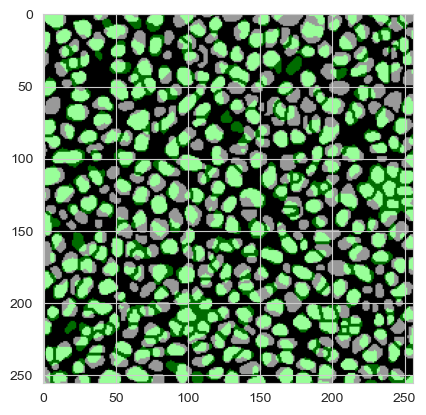

QuPath_dense2
TP:144, FP:137, FN:286, ground truth nuclei:430
F1-score:0.4050632911386708


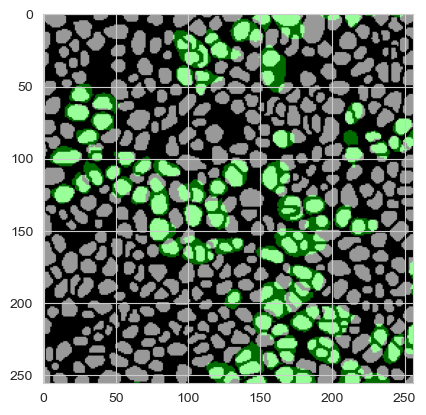

StarDist_dense2
TP:31, FP:48, FN:399, ground truth nuclei:430
F1-score:0.1218074656186212


In [4]:
# this dictionary will be populated with subfield names and their associated F1 scores for each platform
df_dict_F1 = {'subfield': []}
for i in platform_list:
    df_dict_F1[i] = []

# initializing the ground truth nuclei count to be incremented
gr_tr_nuclei_count = []
# iterating over all 4 subfields
for subfield in gr_tr_mask_dict.keys():
    # iterating over each platform's binary mask
    for img in os.listdir(platforms_dir_path):
        # processes only tiff files
        if img[-5:]=='.tiff' or img[-4:]=='.tif':
            platform_whole_img = io.imread(os.path.join(platforms_dir_path, img))
            platform = img[:img.find('.')]
            # adds a new entry in the dictionary for the subfield if it is not already added
            if subfield not in df_dict_F1['subfield']:
                df_dict_F1['subfield'].append(subfield)
            else:
                pass
            # gets the ground truth mask for the current subfield
            gr_tr_img = gr_tr_mask_dict[subfield]
            # gets the coordinates for the current subfield
            top_left_row = coordinate_dict[subfield][0]
            top_left_column = coordinate_dict[subfield][1]
            # crops the platform binary mask to isolate the region to be evaluated
            platform_img = platform_whole_img[top_left_row:top_left_row+256, top_left_column:top_left_column+256]
            # creating a ground truth binary mask for visualization purposes in white and black
            gr_tr_img_show = np.uint8(np.zeros((gr_tr_img.shape[0], gr_tr_img.shape[1], 3)))
            gr_tr_img_show[gr_tr_img == 255] = [255, 255, 255]
            # creating a ground truth binary mask for visualization purposes in green and black
            platform_img_show = np.uint8(np.zeros((platform_img.shape[0], platform_img.shape[1], 3)))
            platform_img_show[platform_img == 255] = [0, 120, 0]
            # overlaying the platform over the ground truth binary mask
            dst = cv2.addWeighted(gr_tr_img_show, 0.6, platform_img_show, 0.9, 0)
            # for visualization in the notebook
            plt.imshow(dst)
            plt.show()
            # to save the overlayed images for qualitative evaluation
            io.imsave(os.path.join(eval_images_path, platform + '_' + subfield + '.tiff'), dst)

            print(platform + '_' + subfield)
            # calculating the F1-score of the current platform subfield
            F1, nuclei_count, cur_gr_tr_nuclei_count, aHD = F1_score_calculator(platform_img, gr_tr_img, 0.5)
            # Adding the F1-score to the F1-score dictionary
            df_dict_F1[platform].append(F1)
        else:
            pass
    # updating the ground truth nuclei count for the current subfield    
    gr_tr_nuclei_count.append(cur_gr_tr_nuclei_count)
# Adding up the ground truth nuclei in all the subfields
gr_tr_nuclei_count = sum(gr_tr_nuclei_count)

# Converting the F1-score dictionary to a dataframe
df_F1 = pd.DataFrame(df_dict_F1)
# Setting the index to be the subfield name
df_F1 = df_F1.set_index('subfield')

In [5]:
print(f'{gr_tr_nuclei_count} ground truth nuclei have been segmented.')

1587 ground truth nuclei have been segmented.


The below figure shows the relative performance of nuclear segmentation platforms on this particular field at an IoU threshold of 0.5:

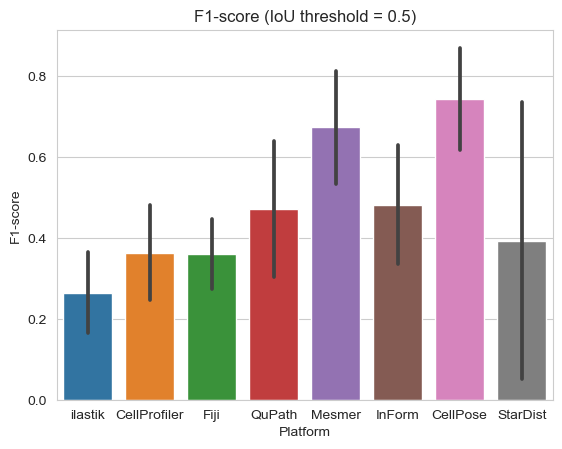

In [6]:
# Creating a barplot with errorbars being one standard deviation
F1_barplot = sns.barplot(data=df_F1, errorbar='sd')
F1_barplot.set(xlabel ="Platform", ylabel = "F1-score", title ='F1-score (IoU threshold = 0.5)')
# saving this figure
plt.savefig(F1_5IoU_plot_path, dpi=500)

It is important to populate these csv files from all the fields into one directory so that they can be compiled to draw conclusions about relative nuclear segmentation performance of the platforms for the whole dataset (using Evaluation Notebook #2).

In [7]:
# converting the dataframe with the F1-scores at 0.5 IoU to a csv file
df_F1.to_csv(F1_5IoU_csv_path)

The below block of code is used to generate a dataframe where the columns are platforms to be evaluated and the rows are the average F1-scores over the 4 subfields at various IoU thresholds (rows correspond to IoU thresholds).

In [8]:
# Initializing the dictionary which will contain the F1-scores (averaged over 4 subfields)
df_mean_dict = {}
df_mean = pd.DataFrame(df_mean_dict)

# Iterating for various IoU thresholds
for IoU_thresh in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:

    # this dictionary will be populated with IoU thresholds and their associated mean F1 scores for each platform.
    df_dict_F1 = {'subfield': []}
    for i in platform_list:
        df_dict_F1[i] = []

    # iterating over all 4 subfields
    for subfield in gr_tr_mask_dict.keys():
        # iterating over each platform's binary mask
        for img in os.listdir(platforms_dir_path):
            # only processed tiff files
            if img[-5:]=='.tiff' or img[-4:]=='.tif':
                platform_whole_img = io.imread(os.path.join(platforms_dir_path, img))
                platform = img[:img.find('.')]
                # adds a new entry in the dictionary for the subfield if it is not already added
                if subfield not in df_dict_F1['subfield']:
                    df_dict_F1['subfield'].append(subfield)
                else:
                    pass
                # gets the ground truth mask for the current subfield
                gr_tr_img = gr_tr_mask_dict[subfield]
                # gets the coordinates for the current subfield
                top_left_row = coordinate_dict[subfield][0]
                top_left_column = coordinate_dict[subfield][1]
                # crops the platform binary mask to isolate the region to be evaluated
                platform_img = platform_whole_img[top_left_row:top_left_row+256,
                                                  top_left_column:top_left_column+256]

                accuracy = accuracy_calculator(platform_img, gr_tr_img)
                # calculating the F1-score of the current platform subfield at the current IoU threshold
                F1, nuclei_count, cur_gr_tr_nuclei_count, aHD = F1_score_calculator(platform_img, gr_tr_img,
                                                                                    IoU_thresh, printing=False)
                # Adding the F1-score to the F1-score dictionary
                df_dict_F1[platform].append(F1)
            else:
                pass
    # Converting the F1-score dictionary to a dataframe
    df_F1 = pd.DataFrame(df_dict_F1)
    # Setting the index to be the subfield name
    df_F1 = df_F1.set_index('subfield')

    # Calculating the mean F1-score over the 4 subfields for each IoU threshold
    df_mean[str(IoU_thresh)] = df_F1.mean()

The below figure shows the relative performance of nuclear segmentation platforms on this particular field at varying IoU thresholds. Higher IoU thresholds result in stricter conditions for a predicted nucleus being classified as a true positive. Hence, F1-scores tend to decrease with increasing IoU thresholds.

C:\Users\mrl\AppData\Local\Temp\ipykernel_27320\4148514152.py:2: UserWarning: 
The markers list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  mean_F1_barplot = sns.lineplot(data=df_mean_transpose, dashes=False, markers='s', legend=True)


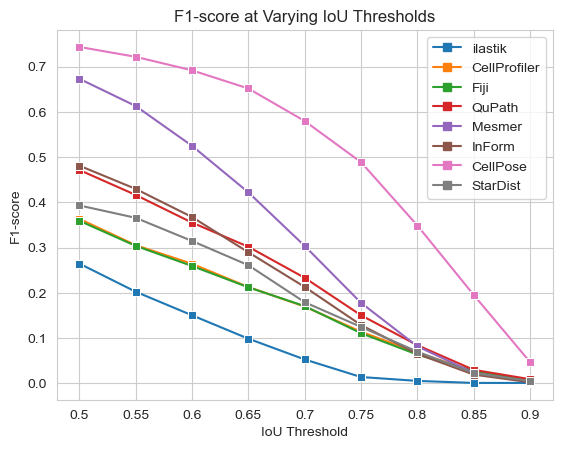

In [9]:
df_mean_transpose = df_mean.transpose()
mean_F1_barplot = sns.lineplot(data=df_mean_transpose, dashes=False, markers='s', legend=True)
mean_F1_barplot.set(xlabel ="IoU Threshold", ylabel = "F1-score", title ='F1-score at Varying IoU Thresholds')
plt.savefig(F1_allIoU_plot_path, dpi=500)

It is important to populate these csv files from all the fields into one directory so that they can be compiled to draw conclusions about relative nuclear segmentation performance of the platforms for the whole dataset (using Evaluation Notebook #2).

In [10]:
# converting the dataframe with the F1-scores at various IoUs to a csv file
df_mean_transpose.to_csv(F1_allIoU_csv_path)